In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy, mse
from keras.optimizers import Adam
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 100
epochs = 10
stats = []

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [6]:
x = Input(shape=input_shape)
h = Conv2D(32, (3, 3), activation='relu')(x)
h = Conv2D(64, (3, 3), activation='relu')(h)
h = MaxPooling2D(pool_size=(2, 2))(h)
h = Dropout(0.25)(h)
h = Flatten()(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.5)(h)
p = Dense(num_classes, activation='softmax')(h)

h = Lambda(lambda x: K.stop_gradient(x))(h)
h = Dense(128, activation='relu')(h)
b = Dense(1)(h)

a = Input(shape=(1,))

model = Model([x, a], [p, b])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 26, 26, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 24, 24, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 12, 12, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [7]:
def policy_gradient_loss(y_true, y_pred):
    return a * sparse_categorical_crossentropy(y_true, y_pred)[:, np.newaxis]

model.compile(loss=[policy_gradient_loss, mse],
              optimizer=Adam(lr=0.0005))

In [8]:
for n in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:(i + batch_size)]
        y_batch = y_train[i:(i + batch_size)]

        # predict class probabilities
        a = np.zeros((x_batch.shape[0], 1))
        y_preds, baselines = model.predict([x_batch, a])

        # sample from those probabilities
        y_sample = np.empty((batch_size,), dtype=np.integer)
        for j, p in enumerate(y_preds):
            y_sample[j] = np.random.choice(num_classes, p=p)

        # calculate accuracy for logging
        y_preds = np.argmax(y_preds, axis=1)
        accuracy = np.mean(y_preds == y_batch)
        baseline = np.mean(baselines)

        # calculate reward and advantage, update baseline
        rewards = (y_sample == y_batch)[:, np.newaxis]
        advantages = rewards - baselines

        # train with samples as targets and advantage as sample weight
        losses = model.train_on_batch([x_batch, advantages], [y_sample, rewards])

        # log statistics
        stats.append(losses + [accuracy, baseline])
        print(i, losses, accuracy, baseline)

(0, [0.42019939, 0.28394008, 0.1362593], 0.14000000000000001, 0.014909601)
(100, [0.49621624, 0.32754624, 0.16867], 0.17999999999999999, 0.034901712)
(200, [0.17167905, 0.070359036, 0.10132001], 0.16, 0.0775268)
(300, [0.091689736, -0.013381667, 0.1050714], 0.19, 0.12471227)
(400, [-0.10300047, -0.1936273, 0.090626828], 0.20000000000000001, 0.1646159)
(500, [-0.054853491, -0.17759256, 0.12273907], 0.20000000000000001, 0.19090463)
(600, [-0.10533801, -0.23131508, 0.12597707], 0.16, 0.21705435)
(700, [-0.021848619, -0.17563179, 0.15378317], 0.22, 0.24098851)
(800, [-0.17021096, -0.30076864, 0.13055769], 0.19, 0.23100676)
(900, [-0.1980646, -0.32637823, 0.12831363], 0.23000000000000001, 0.21280201)
(1000, [0.021513648, -0.11144904, 0.13296269], 0.22, 0.16685577)
(1100, [0.18479636, 0.02048748, 0.16430889], 0.33000000000000002, 0.14385298)
(1200, [0.0010654405, -0.1242112, 0.12527664], 0.28999999999999998, 0.12728338)
(1300, [0.38226423, 0.19270542, 0.1895588], 0.28000000000000003, 0.06784

(11000, [0.28987509, 0.011615157, 0.27825993], 0.76000000000000001, 0.42455423)
(11100, [0.34659633, -0.0053933943, 0.35198972], 0.78000000000000003, 0.54890192)
(11200, [0.41745201, 0.037124272, 0.38032773], 0.82999999999999996, 0.48817393)
(11300, [0.37287116, -0.055283602, 0.42815477], 0.68000000000000005, 0.49585429)
(11400, [0.2931934, -0.070352867, 0.36354628], 0.76000000000000001, 0.45442551)
(11500, [0.68130487, 0.063473038, 0.61783183], 0.67000000000000004, 0.38979575)
(11600, [0.55339479, 0.051967878, 0.50142694], 0.72999999999999998, 0.23270695)
(11700, [0.64846826, 0.14788157, 0.50058669], 0.66000000000000003, 0.13334453)
(11800, [0.77893168, 0.22814383, 0.55078787], 0.70999999999999996, 0.10381047)
(11900, [0.77069402, 0.27318516, 0.49750885], 0.71999999999999997, 0.099068098)
(12000, [0.3736226, -0.026403904, 0.4000265], 0.77000000000000002, 0.26003954)
(12100, [0.35233545, -0.051557459, 0.4038929], 0.72999999999999998, 0.41397423)
(12200, [0.33956033, -0.038372066, 0.377

(21500, [0.31880566, 0.031097678, 0.28770798], 0.70999999999999996, 0.32357654)
(21600, [0.4370437, 0.10515117, 0.33189252], 0.77000000000000002, 0.40978661)
(21700, [0.43105906, 0.044402484, 0.38665658], 0.81999999999999995, 0.47996974)
(21800, [0.36025363, 0.11280005, 0.24745357], 0.83999999999999997, 0.49554661)
(21900, [0.39590114, -0.006156012, 0.40205714], 0.71999999999999997, 0.53704745)
(22000, [0.22545913, -0.02720266, 0.25266179], 0.81999999999999995, 0.48913667)
(22100, [0.27015647, -0.028466322, 0.29862279], 0.72999999999999998, 0.41010776)
(22200, [0.26736161, -0.0098509602, 0.27721256], 0.73999999999999999, 0.37389866)
(22300, [0.3673676, 0.09053456, 0.27683303], 0.84999999999999998, 0.37828475)
(22400, [0.36608654, 0.040993284, 0.32509327], 0.72999999999999998, 0.35157096)
(22500, [0.46310201, 0.074457236, 0.38864478], 0.75, 0.25676194)
(22600, [0.37511712, 0.010652541, 0.36446458], 0.76000000000000001, 0.30424058)
(22700, [0.37972644, 0.11015877, 0.26956767], 0.76000000

(32000, [0.17352924, -0.14576307, 0.31929231], 0.83999999999999997, 0.63052815)
(32100, [0.28084928, 0.03729824, 0.24355103], 0.85999999999999999, 0.56393635)
(32200, [0.3018674, 0.070381425, 0.23148598], 0.82999999999999996, 0.52436751)
(32300, [0.32168159, 0.0054258155, 0.31625578], 0.81000000000000005, 0.47194117)
(32400, [0.26634777, -0.085143499, 0.35149127], 0.82999999999999996, 0.49800521)
(32500, [0.33937168, 0.033870097, 0.30550158], 0.82999999999999996, 0.43470427)
(32600, [0.26289728, 0.0011407429, 0.26175654], 0.88, 0.41033933)
(32700, [0.29723087, -0.042884134, 0.34011501], 0.81000000000000005, 0.41431054)
(32800, [0.2852425, 0.0413578, 0.24388471], 0.84999999999999998, 0.45196626)
(32900, [0.19415709, -0.082335375, 0.27649248], 0.85999999999999999, 0.56077737)
(33000, [0.24058498, -0.026601059, 0.26718605], 0.83999999999999997, 0.60642123)
(33100, [0.25330228, -0.040391296, 0.29369357], 0.80000000000000004, 0.56496501)
(33200, [0.28791907, -0.041055422, 0.32897449], 0.819

(42600, [0.21121685, 0.005843563, 0.20537329], 0.84999999999999998, 0.47831553)
(42700, [0.1568318, 0.023012156, 0.13381964], 0.84999999999999998, 0.48976794)
(42800, [0.18600051, 0.0058501423, 0.18015037], 0.80000000000000004, 0.53945577)
(42900, [0.12571663, -0.088194408, 0.21391104], 0.81999999999999995, 0.58808243)
(43000, [0.044852689, -0.16440716, 0.20925985], 0.79000000000000004, 0.55719751)
(43100, [0.20241277, 0.0039648078, 0.19844796], 0.87, 0.57369608)
(43200, [0.18852265, -0.021159962, 0.20968261], 0.81999999999999995, 0.5727632)
(43300, [0.16410683, -0.016801167, 0.18090799], 0.93000000000000005, 0.59805673)
(43400, [0.18228106, 0.011437664, 0.17084339], 0.84999999999999998, 0.54478753)
(43500, [0.14957149, -0.049984861, 0.19955635], 0.89000000000000001, 0.57564729)
(43600, [0.2156122, 0.033795059, 0.18181714], 0.85999999999999999, 0.60698539)
(43700, [0.048540935, -0.097429797, 0.14597073], 0.89000000000000001, 0.59877127)
(43800, [0.20067935, -0.034070622, 0.23474997], 0

(53600, [0.18400128, -0.0081152031, 0.19211648], 0.89000000000000001, 0.5649668)
(53700, [0.14603364, -0.0036643287, 0.14969797], 0.88, 0.58992386)
(53800, [0.13394314, -0.040711068, 0.1746542], 0.83999999999999997, 0.58713388)
(53900, [0.18633224, -0.0018244493, 0.18815669], 0.81000000000000005, 0.49390045)
(54000, [0.21445727, 0.063389972, 0.1510673], 0.87, 0.50409448)
(54100, [0.15129916, 0.00049952389, 0.15079965], 0.92000000000000004, 0.5610714)
(54200, [0.19376008, 0.042554036, 0.15120605], 0.88, 0.5554775)
(54300, [0.13989137, -0.014883684, 0.15477505], 0.84999999999999998, 0.53354955)
(54400, [0.13417624, -0.010392835, 0.14456907], 0.85999999999999999, 0.5596903)
(54500, [0.20858094, 0.0090504745, 0.19953047], 0.85999999999999999, 0.61742443)
(54600, [0.084235199, -0.042925559, 0.12716076], 0.85999999999999999, 0.56365484)
(54700, [0.16264361, 0.012477083, 0.15016653], 0.91000000000000003, 0.54845858)
(54800, [0.042514667, -0.14145993, 0.18397459], 0.77000000000000002, 0.524454

(4600, [0.19649877, 0.024922192, 0.17157657], 0.84999999999999998, 0.51977599)
(4700, [0.23151225, 0.034396704, 0.19711554], 0.88, 0.49891144)
(4800, [0.21842055, 0.057926472, 0.16049407], 0.90000000000000002, 0.48680472)
(4900, [0.15004075, -0.033333745, 0.18337449], 0.84999999999999998, 0.41117844)
(5000, [0.13546976, -0.0097780786, 0.14524785], 0.84999999999999998, 0.45834392)
(5100, [0.11880209, -0.022944929, 0.14174701], 0.80000000000000004, 0.50744838)
(5200, [0.11037318, -0.0031622262, 0.1135354], 0.84999999999999998, 0.60372812)
(5300, [0.050533697, -0.10536946, 0.15590316], 0.82999999999999996, 0.61675698)
(5400, [0.059964418, -0.034852639, 0.094817057], 0.90000000000000002, 0.59546554)
(5500, [0.16833797, 0.039223831, 0.12911414], 0.87, 0.51129365)
(5600, [0.11420086, -0.047224522, 0.16142538], 0.78000000000000003, 0.46603119)
(5700, [0.15776144, 0.0055634296, 0.15219802], 0.89000000000000001, 0.51058012)
(5800, [0.20995817, 0.054532602, 0.15542556], 0.87, 0.48092747)
(5900, 

(15600, [0.17251638, 0.017213102, 0.15530327], 0.85999999999999999, 0.57042032)
(15700, [0.093939424, -0.029359244, 0.12329867], 0.82999999999999996, 0.53886878)
(15800, [0.19233385, 0.068090349, 0.1242435], 0.85999999999999999, 0.57439727)
(15900, [0.18247694, 0.018582962, 0.16389397], 0.82999999999999996, 0.63810593)
(16000, [0.13085088, -0.047094669, 0.17794555], 0.91000000000000003, 0.66171455)
(16100, [0.18130231, 0.040887453, 0.14041485], 0.87, 0.60001034)
(16200, [0.15815651, 0.032017227, 0.12613928], 0.91000000000000003, 0.5633654)
(16300, [0.16836974, 0.026433041, 0.1419367], 0.88, 0.48994145)
(16400, [0.10968359, -0.0054588802, 0.11514247], 0.84999999999999998, 0.53388399)
(16500, [0.1038059, -0.0082978336, 0.11210373], 0.85999999999999999, 0.56365854)
(16600, [0.16728921, 0.015312322, 0.15197688], 0.87, 0.59272772)
(16700, [0.13026145, -0.015528668, 0.14579011], 0.90000000000000002, 0.70316404)
(16800, [0.13904808, -0.0028746696, 0.14192276], 0.93000000000000005, 0.65881407)

(26600, [-0.0019461811, -0.13114655, 0.12920037], 0.84999999999999998, 0.68586427)
(26700, [0.13077277, -0.0096475156, 0.14042029], 0.84999999999999998, 0.73357183)
(26800, [0.17547263, 0.012998261, 0.16247436], 0.87, 0.7059651)
(26900, [0.083832532, -0.020246495, 0.10407903], 0.91000000000000003, 0.6698404)
(27000, [0.12019876, 0.026415823, 0.093782939], 0.89000000000000001, 0.58843893)
(27100, [0.16882139, 0.037740167, 0.13108122], 0.89000000000000001, 0.52288401)
(27200, [0.17050704, 0.024360523, 0.14614652], 0.83999999999999997, 0.45808089)
(27300, [0.15140076, 0.039290931, 0.11210983], 0.87, 0.49758297)
(27400, [0.12133756, -0.02893276, 0.15027031], 0.81000000000000005, 0.53803247)
(27500, [0.11813493, 0.0029832767, 0.11515165], 0.90000000000000002, 0.56698209)
(27600, [0.12759922, 0.0060103964, 0.12158883], 0.83999999999999997, 0.58781981)
(27700, [0.1131495, 0.0053946148, 0.10775489], 0.92000000000000004, 0.64594704)
(27800, [0.077343427, -0.029805185, 0.10714861], 0.83999999999

(37600, [0.11377538, -0.019133991, 0.13290937], 0.88, 0.49339622)
(37700, [0.090850316, 0.0070112809, 0.083839037], 0.85999999999999999, 0.52967036)
(37800, [0.11364794, 0.011095311, 0.10255263], 0.88, 0.58933032)
(37900, [0.077760123, -0.021397404, 0.099157527], 0.82999999999999996, 0.57581729)
(38000, [-0.016371861, -0.097518481, 0.08114662], 0.89000000000000001, 0.60445291)
(38100, [0.10218189, 0.0097470451, 0.092434846], 0.81999999999999995, 0.56194532)
(38200, [0.12019943, 0.018983454, 0.10121597], 0.92000000000000004, 0.57243174)
(38300, [0.10915712, -0.011354301, 0.12051142], 0.88, 0.63131416)
(38400, [0.074028656, 0.0048824647, 0.069146194], 0.85999999999999999, 0.54105639)
(38500, [0.13436522, 0.0021745237, 0.13219069], 0.87, 0.5347259)
(38600, [0.095606819, 0.012162699, 0.083444118], 0.87, 0.55505091)
(38700, [0.07658682, -0.034081541, 0.11066836], 0.88, 0.5976969)
(38800, [0.089697123, 0.005279066, 0.084418058], 0.90000000000000002, 0.59551835)
(38900, [0.10378312, 0.0022494

(48300, [0.13680318, 0.03535293, 0.10145025], 0.91000000000000003, 0.64773202)
(48400, [0.096253015, 0.028898126, 0.067354888], 0.89000000000000001, 0.59599751)
(48500, [0.057217568, -0.01988194, 0.07709951], 0.85999999999999999, 0.61836678)
(48600, [0.0098710731, -0.065395921, 0.075266995], 0.83999999999999997, 0.61263776)
(48700, [0.10651347, 0.011186092, 0.095327377], 0.89000000000000001, 0.65025347)
(48800, [0.068702392, -0.02115223, 0.08985462], 0.93000000000000005, 0.62101352)
(48900, [0.13022144, -0.007665786, 0.13788722], 0.88, 0.63362294)
(49000, [0.023609847, -0.13608488, 0.15969473], 0.83999999999999997, 0.5991565)
(49100, [0.00034639239, -0.098049745, 0.098396137], 0.88, 0.58413595)
(49200, [0.0044567436, -0.15799899, 0.16245574], 0.81000000000000005, 0.57270318)
(49300, [0.095279381, 0.01635351, 0.07892587], 0.83999999999999997, 0.52452517)
(49400, [0.12986931, 0.0044641066, 0.12540521], 0.89000000000000001, 0.55652654)
(49500, [0.05578877, -0.095622137, 0.15141091], 0.780

(59300, [0.055585876, -0.013672649, 0.069258526], 0.89000000000000001, 0.65288651)
(59400, [-0.05912929, -0.14664584, 0.087516554], 0.88, 0.76496661)
(59500, [0.059426792, -0.003415823, 0.062842615], 0.92000000000000004, 0.74573946)
(59600, [-0.0038887039, -0.093067542, 0.089178838], 0.89000000000000001, 0.62630254)
(59700, [0.20593658, 0.095237769, 0.11069881], 0.82999999999999996, 0.55891281)
(59800, [0.12359393, 0.028965252, 0.094628684], 0.92000000000000004, 0.55849171)
(59900, [0.1230448, 0.0049327137, 0.11811208], 0.89000000000000001, 0.51658702)
(0, [0.10738545, 0.0067873271, 0.10059812], 0.84999999999999998, 0.54348987)
(100, [0.060705032, -0.024147559, 0.084852591], 0.88, 0.65832412)
(200, [0.023221962, -0.092648841, 0.1158708], 0.83999999999999997, 0.71113205)
(300, [0.075686052, -0.0066224863, 0.082308538], 0.93999999999999995, 0.73734671)
(400, [0.037873462, -0.028442526, 0.066315986], 0.88, 0.60694152)
(500, [0.0068366826, -0.089205272, 0.096041955], 0.89000000000000001, 0

(10300, [0.024957724, -0.055679113, 0.080636837], 0.87, 0.61375201)
(10400, [0.15567674, 0.077273414, 0.078403324], 0.91000000000000003, 0.65931094)
(10500, [0.06102125, 0.0069847228, 0.054036528], 0.91000000000000003, 0.66888618)
(10600, [0.060586441, 0.0031841344, 0.057402305], 0.93999999999999995, 0.7318939)
(10700, [0.079754025, -0.030644648, 0.11039867], 0.91000000000000003, 0.73059243)
(10800, [0.076540731, 0.0029955902, 0.073545143], 0.89000000000000001, 0.65778941)
(10900, [0.051353067, -0.081146568, 0.13249964], 0.89000000000000001, 0.62277186)
(11000, [0.072770551, -0.039168578, 0.11193913], 0.81999999999999995, 0.53482711)
(11100, [0.1171205, 0.033576846, 0.083543651], 0.92000000000000004, 0.59354734)
(11200, [0.070734143, -0.010753823, 0.081487969], 0.89000000000000001, 0.59652376)
(11300, [0.098040603, -0.0051469561, 0.10318756], 0.88, 0.63395888)
(11400, [0.068335243, -0.0088739488, 0.07720919], 0.91000000000000003, 0.64556259)
(11500, [-0.1197145, -0.23874298, 0.11902848

(21300, [0.24656852, 0.077935234, 0.16863328], 0.88, 0.53989363)
(21400, [0.21899153, 0.11660883, 0.1023827], 0.94999999999999996, 0.56371891)
(21500, [-0.05271773, -0.14127812, 0.088560387], 0.84999999999999998, 0.68631065)
(21600, [0.0077104196, -0.098601386, 0.10631181], 0.87, 0.78200603)
(21700, [0.043714829, -0.061866112, 0.10558094], 0.88, 0.71242553)
(21800, [0.080950134, 0.0080477623, 0.072902374], 0.93000000000000005, 0.64596277)
(21900, [0.29070717, 0.19759376, 0.093113415], 0.82999999999999996, 0.52519631)
(22000, [0.24177927, 0.099294297, 0.14248496], 0.91000000000000003, 0.58849424)
(22100, [-0.16834797, -0.31170768, 0.14335971], 0.92000000000000004, 0.70000428)
(22200, [-0.039140806, -0.17915523, 0.14001442], 0.83999999999999997, 0.74889624)
(22300, [-0.10446773, -0.2213825, 0.11691477], 0.89000000000000001, 0.81346893)
(22400, [0.07837493, -0.021907663, 0.10028259], 0.83999999999999997, 0.61939162)
(22500, [0.27995324, 0.1219578, 0.15799543], 0.89000000000000001, 0.46783

(32200, [0.10425709, 0.00079872966, 0.10345836], 0.89000000000000001, 0.8037805)
(32300, [0.11138469, -0.031410944, 0.14279564], 0.89000000000000001, 0.80323136)
(32400, [0.086289927, -0.023758844, 0.11004877], 0.85999999999999999, 0.66784674)
(32500, [0.19453672, 0.092619136, 0.10191757], 0.88, 0.53825974)
(32600, [0.13664874, 0.017620269, 0.11902847], 0.90000000000000002, 0.5104093)
(32700, [0.098423384, 0.01960762, 0.078815766], 0.89000000000000001, 0.57249385)
(32800, [0.025198981, -0.056155868, 0.081354849], 0.87, 0.73345232)
(32900, [-0.0086621419, -0.085912943, 0.077250801], 0.91000000000000003, 0.83759761)
(33000, [0.021394454, -0.072509557, 0.093904011], 0.89000000000000001, 0.76236421)
(33100, [0.050946534, -0.027636496, 0.078583032], 0.85999999999999999, 0.63712835)
(33200, [0.030758545, -0.076430723, 0.10718927], 0.82999999999999996, 0.58322322)
(33300, [0.15002042, 0.055935897, 0.094084531], 0.82999999999999996, 0.57444417)
(33400, [0.11133235, 0.017159099, 0.094173253], 0

(43100, [-0.029036298, -0.096260414, 0.067224115], 0.90000000000000002, 0.71508783)
(43200, [0.11790328, 0.039186791, 0.078716487], 0.84999999999999998, 0.6778509)
(43300, [0.092314251, 0.024991021, 0.06732323], 0.94999999999999996, 0.71417898)
(43400, [0.013774041, -0.048201494, 0.061975535], 0.88, 0.62872499)
(43500, [0.14007398, 0.06070821, 0.079365775], 0.90000000000000002, 0.62900591)
(43600, [0.051513687, -0.0092128823, 0.060726568], 0.90000000000000002, 0.64572698)
(43700, [0.07672257, 0.024430312, 0.052292258], 0.91000000000000003, 0.68820918)
(43800, [0.083715267, 0.028331246, 0.055384021], 0.93999999999999995, 0.73637968)
(43900, [0.081497028, 0.0094400235, 0.072057001], 0.85999999999999999, 0.66080385)
(44000, [0.12070996, 0.036185309, 0.084524654], 0.85999999999999999, 0.6479513)
(44100, [0.12438294, 0.045987032, 0.078395911], 0.91000000000000003, 0.66760314)
(44200, [0.058193404, -0.0015438914, 0.059737295], 0.91000000000000003, 0.67862874)
(44300, [0.017948758, -0.0399626

(53700, [0.050423659, 0.0025648717, 0.047858786], 0.93999999999999995, 0.71385801)
(53800, [0.028191045, -0.051383562, 0.079574607], 0.87, 0.72071719)
(53900, [-0.062872075, -0.13918336, 0.076311283], 0.84999999999999998, 0.64658487)
(54000, [0.030118994, -0.041913845, 0.072032839], 0.92000000000000004, 0.66058183)
(54100, [0.015357643, -0.03488265, 0.050240293], 0.93000000000000005, 0.71468782)
(54200, [0.10778837, 0.044341825, 0.063446544], 0.88, 0.6663425)
(54300, [0.014886308, -0.03232149, 0.047207799], 0.87, 0.64981806)
(54400, [0.046748132, -0.0062876074, 0.05303574], 0.89000000000000001, 0.6841675)
(54500, [0.016136054, -0.050874468, 0.067010522], 0.89000000000000001, 0.72811651)
(54600, [0.041224241, -0.0064331312, 0.047657374], 0.90000000000000002, 0.68918467)
(54700, [0.019885564, -0.022975268, 0.042860832], 0.91000000000000003, 0.67695677)
(54800, [-0.090933539, -0.1940631, 0.10312956], 0.79000000000000004, 0.62158823)
(54900, [0.03564702, -0.019328246, 0.054975267], 0.84999

(4600, [-0.11649824, -0.19731905, 0.080820806], 0.87, 0.79895949)
(4700, [0.14207777, 0.074742652, 0.067335114], 0.88, 0.67211062)
(4800, [0.13502504, 0.043465529, 0.091559514], 0.92000000000000004, 0.56426108)
(4900, [0.23962504, 0.17315094, 0.066474102], 0.87, 0.59013331)
(5000, [0.099625312, 0.020438218, 0.079187095], 0.85999999999999999, 0.63769329)
(5100, [-0.048712231, -0.13734649, 0.08863426], 0.83999999999999997, 0.70769531)
(5200, [0.023627989, -0.046840571, 0.07046856], 0.83999999999999997, 0.76983321)
(5300, [-0.096064888, -0.17067394, 0.074609049], 0.84999999999999998, 0.7120108)
(5400, [0.05791261, 0.014856052, 0.043056559], 0.90000000000000002, 0.64021409)
(5500, [0.08127553, 0.034029581, 0.04724595], 0.88, 0.61218405)
(5600, [0.060632959, -0.010754287, 0.071387246], 0.81000000000000005, 0.56107163)
(5700, [0.020704955, -0.062930778, 0.083635733], 0.90000000000000002, 0.70940298)
(5800, [0.040958449, -0.053199157, 0.094157606], 0.87, 0.73408514)
(5900, [-0.018972896, -0.0

(15200, [-0.071278915, -0.12028126, 0.049002338], 0.92000000000000004, 0.70851046)
(15300, [-0.018830348, -0.081106797, 0.062276449], 0.89000000000000001, 0.681427)
(15400, [0.014156859, -0.037155624, 0.051312484], 0.90000000000000002, 0.68142229)
(15500, [0.083562717, 0.034810089, 0.048752632], 0.81999999999999995, 0.63360643)
(15600, [0.015686234, -0.023003543, 0.038689777], 0.88, 0.71469635)
(15700, [0.0029410198, -0.061399363, 0.064340383], 0.85999999999999999, 0.72385591)
(15800, [0.091331497, 0.015620614, 0.075710885], 0.87, 0.68754518)
(15900, [0.16697651, 0.11576442, 0.051212102], 0.87, 0.6583817)
(16000, [0.053892393, -0.011406568, 0.06529896], 0.93000000000000005, 0.68830442)
(16100, [0.098916419, 0.023364281, 0.075552136], 0.88, 0.6822927)
(16200, [0.0052249879, -0.046939835, 0.052164823], 0.91000000000000003, 0.80851251)
(16300, [0.049864255, -0.022051638, 0.071915895], 0.88, 0.75089693)
(16400, [0.052908216, -0.001148242, 0.054056458], 0.85999999999999999, 0.68466866)
(165

(25900, [0.06858895, 0.021813659, 0.046775293], 0.87, 0.63210845)
(26000, [0.10414951, 0.062236935, 0.041912571], 0.91000000000000003, 0.65061897)
(26100, [0.0076723658, -0.035009794, 0.04268216], 0.91000000000000003, 0.74572855)
(26200, [-0.0001289323, -0.069733389, 0.069604456], 0.85999999999999999, 0.7691794)
(26300, [0.0032392293, -0.084056683, 0.087295912], 0.84999999999999998, 0.74701554)
(26400, [0.057189401, -0.021911193, 0.079100594], 0.88, 0.64228708)
(26500, [0.14810517, 0.083421372, 0.064683802], 0.92000000000000004, 0.61719197)
(26600, [0.059082359, -0.0089094918, 0.067991853], 0.85999999999999999, 0.70646256)
(26700, [-0.065461472, -0.12539326, 0.059931785], 0.88, 0.80340898)
(26800, [-0.063868575, -0.15045302, 0.086584441], 0.88, 0.76793444)
(26900, [0.018909207, -0.018731983, 0.03764119], 0.92000000000000004, 0.69038057)
(27000, [0.052690808, 0.0051253922, 0.047565416], 0.90000000000000002, 0.64394343)
(27100, [0.11318918, 0.017044948, 0.096144229], 0.90000000000000002,

(36800, [-0.24333069, -0.3272287, 0.083898008], 0.87, 0.78462595)
(36900, [0.077054918, 0.035820473, 0.041234449], 0.91000000000000003, 0.70594668)
(37000, [0.099273138, 0.021284424, 0.077988714], 0.88, 0.64337081)
(37100, [0.035734434, -0.01670016, 0.052434593], 0.90000000000000002, 0.68401939)
(37200, [-0.039177943, -0.086082183, 0.04690424], 0.92000000000000004, 0.78579402)
(37300, [0.12287252, 0.083022229, 0.039850283], 0.93000000000000005, 0.84300494)
(37400, [-0.044994432, -0.10141645, 0.056422014], 0.88, 0.80425584)
(37500, [0.01293727, -0.036180139, 0.049117409], 0.90000000000000002, 0.758757)
(37600, [0.10954084, 0.049403612, 0.060137223], 0.89000000000000001, 0.6517967)
(37700, [0.021977356, -0.021466849, 0.043444205], 0.85999999999999999, 0.65834749)
(37800, [0.02873902, -0.057413206, 0.086152226], 0.87, 0.72670573)
(37900, [-0.020565085, -0.092014618, 0.071449533], 0.81999999999999995, 0.66761184)
(38000, [0.039826222, -0.00086518569, 0.040691409], 0.89000000000000001, 0.65

(47700, [-0.0029103607, -0.056203704, 0.053293344], 0.87, 0.66995287)
(47800, [0.162806, 0.12394825, 0.038857765], 0.90000000000000002, 0.65988624)
(47900, [0.044107106, -0.031895813, 0.076002918], 0.88, 0.70937902)
(48000, [0.063994475, -0.0035729848, 0.06756746], 0.91000000000000003, 0.81217086)
(48100, [-0.053008024, -0.096281931, 0.043273907], 0.85999999999999999, 0.79751158)
(48200, [0.036483906, -0.029554628, 0.066038534], 0.85999999999999999, 0.74995589)
(48300, [0.14607346, 0.098594896, 0.047478568], 0.93000000000000005, 0.70251358)
(48400, [0.14190894, 0.090198748, 0.051710196], 0.89000000000000001, 0.58112413)
(48500, [0.20525321, 0.14467481, 0.060578402], 0.90000000000000002, 0.62988877)
(48600, [-0.099118322, -0.15093343, 0.051815104], 0.83999999999999997, 0.75527322)
(48700, [-0.048404947, -0.10744303, 0.05903808], 0.90000000000000002, 0.87202215)
(48800, [-0.08011093, -0.12816186, 0.048050933], 0.92000000000000004, 0.86045802)
(48900, [-0.068178162, -0.14832389, 0.0801457

(58600, [-0.088026285, -0.1308751, 0.042848814], 0.90000000000000002, 0.80304825)
(58700, [-0.050232202, -0.084762432, 0.03453023], 0.90000000000000002, 0.82202393)
(58800, [-0.093913421, -0.15399468, 0.060081258], 0.88, 0.81237167)
(58900, [0.20656675, 0.16762719, 0.038939565], 0.93999999999999995, 0.69542861)
(59000, [0.22745287, 0.16670385, 0.060749024], 0.90000000000000002, 0.6156776)
(59100, [0.093285583, 0.062050309, 0.031235276], 0.89000000000000001, 0.7287789)
(59200, [-0.048135333, -0.090925694, 0.042790361], 0.90000000000000002, 0.82862359)
(59300, [-0.051639859, -0.096054494, 0.044414636], 0.91000000000000003, 0.8421855)
(59400, [-0.3366144, -0.411309, 0.074694604], 0.85999999999999999, 0.81740308)
(59500, [0.019206239, -0.016639141, 0.03584538], 0.92000000000000004, 0.72900271)
(59600, [0.076639488, 0.021383403, 0.055256084], 0.89000000000000001, 0.62818813)
(59700, [-0.20624706, -0.28335851, 0.07711146], 0.82999999999999996, 0.68311942)
(59800, [-0.0016534328, -0.039319448

(9400, [-0.07976681, -0.16250932, 0.082742512], 0.78000000000000003, 0.66238165)
(9500, [0.081023254, 0.037898973, 0.043124281], 0.93000000000000005, 0.70950699)
(9600, [0.01537082, -0.049665842, 0.065036662], 0.89000000000000001, 0.70356733)
(9700, [-0.049018346, -0.11478716, 0.065768816], 0.85999999999999999, 0.73767722)
(9800, [0.092974603, 0.054745506, 0.038229093], 0.87, 0.71546012)
(9900, [0.043845691, -0.014421301, 0.058266994], 0.87, 0.75938421)
(10000, [-0.063247599, -0.11872541, 0.055477813], 0.88, 0.7344076)
(10100, [0.017331269, -0.036098119, 0.053429388], 0.88, 0.77218628)
(10200, [-0.085673831, -0.16271271, 0.077038877], 0.81999999999999995, 0.69216615)
(10300, [-0.025615714, -0.085080311, 0.059464596], 0.85999999999999999, 0.72605467)
(10400, [0.13258798, 0.099992722, 0.032595266], 0.92000000000000004, 0.72459966)
(10500, [0.016598778, -0.017466186, 0.034064963], 0.91000000000000003, 0.75261194)
(10600, [-0.028844271, -0.058414157, 0.029569887], 0.93999999999999995, 0.79

(20100, [-0.013057295, -0.059637714, 0.046580419], 0.89000000000000001, 0.77958679)
(20200, [0.002500698, -0.049070477, 0.051571175], 0.90000000000000002, 0.76010621)
(20300, [-0.00046278164, -0.047285572, 0.04682279], 0.89000000000000001, 0.77878457)
(20400, [-0.0012929067, -0.041230358, 0.039937451], 0.90000000000000002, 0.81504107)
(20500, [0.060259361, 0.016988698, 0.043270662], 0.90000000000000002, 0.78608102)
(20600, [0.14805721, 0.085891716, 0.062165488], 0.83999999999999997, 0.68369943)
(20700, [0.27214992, 0.18848862, 0.083661295], 0.88, 0.67138898)
(20800, [-0.15045653, -0.19908217, 0.048625637], 0.87, 0.74956757)
(20900, [-0.25248888, -0.32880005, 0.076311164], 0.84999999999999998, 0.81074625)
(21000, [-0.12820409, -0.18548372, 0.057279635], 0.89000000000000001, 0.84002906)
(21100, [0.014504556, -0.037897225, 0.052401781], 0.92000000000000004, 0.73579031)
(21200, [0.10827313, 0.047611661, 0.060661465], 0.89000000000000001, 0.63047308)
(21300, [0.058357224, -0.025006592, 0.08

(30800, [0.17241359, 0.11176328, 0.060650304], 0.90000000000000002, 0.76240218)
(30900, [0.13362193, 0.086422518, 0.047199417], 0.88, 0.75088042)
(31000, [0.0029472485, -0.047128897, 0.050076146], 0.92000000000000004, 0.76848239)
(31100, [-0.47840056, -0.55763251, 0.079231948], 0.81000000000000005, 0.77209353)
(31200, [0.066946164, 0.019041911, 0.047904253], 0.91000000000000003, 0.72867411)
(31300, [-0.013386637, -0.066711172, 0.053324535], 0.87, 0.6870414)
(31400, [0.021105174, -0.033000924, 0.054106098], 0.88, 0.70267522)
(31500, [0.037701514, -0.0090509681, 0.046752483], 0.90000000000000002, 0.77322298)
(31600, [-0.083908767, -0.13292971, 0.04902095], 0.89000000000000001, 0.77356601)
(31700, [-0.10595407, -0.17564432, 0.069690257], 0.90000000000000002, 0.79731077)
(31800, [0.033375509, -0.013552295, 0.046927806], 0.90000000000000002, 0.74563026)
(31900, [0.086992323, 0.030089635, 0.056902684], 0.92000000000000004, 0.7288962)
(32000, [0.10412357, 0.041607946, 0.062515624], 0.89000000

(41600, [-0.081940547, -0.14940043, 0.067459881], 0.81999999999999995, 0.78520906)
(41700, [-0.13299929, -0.17878138, 0.045782093], 0.93000000000000005, 0.91848636)
(41800, [-0.30085984, -0.38372272, 0.082862876], 0.85999999999999999, 0.83320427)
(41900, [0.14053184, 0.058243513, 0.082288332], 0.90000000000000002, 0.72939539)
(42000, [0.42453474, 0.33784768, 0.086687051], 0.85999999999999999, 0.62227583)
(42100, [-0.14195959, -0.19167042, 0.049710825], 0.88, 0.69846898)
(42200, [-0.21734296, -0.25920385, 0.04186089], 0.89000000000000001, 0.78308576)
(42300, [-0.076755047, -0.13274223, 0.055987183], 0.91000000000000003, 0.85732043)
(42400, [-0.44107226, -0.5319714, 0.09089914], 0.85999999999999999, 0.79038793)
(42500, [0.0022549778, -0.072442934, 0.074697912], 0.93000000000000005, 0.71505541)
(42600, [0.054915302, -0.013175228, 0.068090528], 0.87, 0.68858939)
(42700, [-0.15459007, -0.21590973, 0.06131966], 0.87, 0.80901992)
(42800, [-0.26050937, -0.3183417, 0.057832342], 0.8599999999999

(52600, [-0.032011181, -0.063036077, 0.031024896], 0.87, 0.81215167)
(52700, [0.058477819, 0.0079501234, 0.050527696], 0.92000000000000004, 0.79869443)
(52800, [0.16163664, 0.079488456, 0.082148179], 0.83999999999999997, 0.73923707)
(52900, [0.012044199, -0.044440545, 0.056484744], 0.88, 0.72848719)
(53000, [0.02946878, -0.016153691, 0.045622472], 0.91000000000000003, 0.77030951)
(53100, [-0.17579879, -0.23488043, 0.05908164], 0.88, 0.84272248)
(53200, [0.0067963451, -0.03524968, 0.042046025], 0.88, 0.82045591)
(53300, [-0.13125491, -0.18219681, 0.050941899], 0.87, 0.76938981)
(53400, [-0.02992652, -0.069707856, 0.039781336], 0.88, 0.71365035)
(53500, [0.11838739, 0.082979105, 0.035408288], 0.89000000000000001, 0.67684275)
(53600, [-0.033002082, -0.073092826, 0.040090743], 0.89000000000000001, 0.78045714)
(53700, [0.044960555, 0.018196058, 0.026764497], 0.93999999999999995, 0.85217202)
(53800, [-0.21238302, -0.28094131, 0.068558291], 0.87, 0.83424413)
(53900, [-0.12510599, -0.18057814,

(3300, [0.095726743, 0.051881623, 0.043845125], 0.90000000000000002, 0.73114341)
(3400, [-0.033559091, -0.060620762, 0.027061669], 0.90000000000000002, 0.76348817)
(3500, [0.17533135, 0.107283, 0.068048351], 0.87, 0.78455102)
(3600, [-0.12557963, -0.18595919, 0.060379568], 0.85999999999999999, 0.80648482)
(3700, [0.13365994, 0.080004424, 0.05365552], 0.89000000000000001, 0.77409232)
(3800, [0.098851405, 0.069533251, 0.029318152], 0.90000000000000002, 0.7616455)
(3900, [0.01730247, -0.022621451, 0.039923921], 0.93000000000000005, 0.79807854)
(4000, [0.13705415, 0.10228652, 0.034767624], 0.91000000000000003, 0.76900882)
(4100, [0.085877374, 0.042639993, 0.043237377], 0.90000000000000002, 0.81581724)
(4200, [-0.080415078, -0.11745217, 0.037037097], 0.85999999999999999, 0.76061577)
(4300, [-0.020848304, -0.07129211, 0.050443806], 0.87, 0.75473893)
(4400, [-0.00061751902, -0.050109487, 0.049491968], 0.90000000000000002, 0.80673432)
(4500, [-0.040719844, -0.089942075, 0.049222231], 0.87, 0.7

(14000, [-0.013686139, -0.052754093, 0.039067954], 0.89000000000000001, 0.74964577)
(14100, [-0.060504738, -0.098089211, 0.037584472], 0.87, 0.75070959)
(14200, [-0.058770746, -0.091853932, 0.033083186], 0.91000000000000003, 0.82918876)
(14300, [-0.26886702, -0.34843311, 0.079566099], 0.87, 0.86114967)
(14400, [-0.046165228, -0.067884699, 0.021719471], 0.90000000000000002, 0.80880129)
(14500, [-0.013270628, -0.063114844, 0.049844217], 0.88, 0.75072789)
(14600, [-0.33547699, -0.38040024, 0.044923231], 0.92000000000000004, 0.79499429)
(14700, [-0.14587352, -0.21332055, 0.067447029], 0.87, 0.76087415)
(14800, [0.15369321, 0.11265394, 0.041039277], 0.93000000000000005, 0.74961334)
(14900, [-0.058027048, -0.10759605, 0.049569007], 0.91000000000000003, 0.80848908)
(15000, [-0.10788804, -0.14972232, 0.041834284], 0.91000000000000003, 0.89163774)
(15100, [-0.1019398, -0.19252741, 0.090587616], 0.84999999999999998, 0.83995473)
(15200, [0.10857268, 0.072502986, 0.036069695], 0.92000000000000004,

(24900, [-0.24172215, -0.28962281, 0.047900666], 0.91000000000000003, 0.88324702)
(25000, [-0.25084928, -0.2891615, 0.038312238], 0.91000000000000003, 0.8424353)
(25100, [0.014618147, -0.037037872, 0.051656019], 0.92000000000000004, 0.75024939)
(25200, [-0.040872976, -0.076725245, 0.035852268], 0.93000000000000005, 0.76131934)
(25300, [-0.37878621, -0.42890602, 0.05011981], 0.87, 0.82511908)
(25400, [-0.49451095, -0.56138378, 0.066872843], 0.90000000000000002, 0.90191752)
(25500, [-0.22641596, -0.28037614, 0.053960171], 0.90000000000000002, 0.83681643)
(25600, [0.090157717, 0.034069296, 0.056088425], 0.93000000000000005, 0.68268806)
(25700, [0.11949092, 0.029330101, 0.090160817], 0.87, 0.65900022)
(25800, [-0.20712104, -0.26777938, 0.060658332], 0.91000000000000003, 0.90139145)
(25900, [-0.34134609, -0.39852348, 0.05717741], 0.88, 0.92598528)
(26000, [0.36860752, 0.32045519, 0.048152331], 0.91000000000000003, 0.75281012)
(26100, [0.35136306, 0.29858765, 0.052775413], 0.9100000000000000

(35600, [-0.65482569, -0.77360785, 0.11878215], 0.82999999999999996, 0.98803008)
(35700, [-0.090946391, -0.13874763, 0.047801238], 0.84999999999999998, 0.66119766)
(35800, [0.33129859, 0.20069148, 0.13060711], 0.90000000000000002, 0.54206342)
(35900, [-0.094017506, -0.1499977, 0.055980194], 0.85999999999999999, 0.74603426)
(36000, [-0.20760889, -0.31080329, 0.1031944], 0.92000000000000004, 1.0195323)
(36100, [-0.32473397, -0.45714378, 0.1324098], 0.88, 1.0148822)
(36200, [0.47778311, 0.38317016, 0.094612949], 0.89000000000000001, 0.62006027)
(36300, [0.88258708, 0.71985704, 0.16273007], 0.90000000000000002, 0.50326681)
(36400, [-0.29903263, -0.37031704, 0.071284398], 0.90000000000000002, 0.91068113)
(36500, [-0.91701245, -1.1754749, 0.2584624], 0.84999999999999998, 1.1711456)
(36600, [-0.19735992, -0.23485751, 0.037497602], 0.91000000000000003, 0.82117927)
(36700, [0.91948795, 0.72053903, 0.19894893], 0.85999999999999999, 0.43856752)
(36800, [0.25920087, 0.14978081, 0.10942006], 0.88, 

(46500, [-0.1605759, -0.23619673, 0.075620838], 0.91000000000000003, 0.98726344)
(46600, [-0.097447887, -0.14182672, 0.044378828], 0.87, 0.84153765)
(46700, [0.43825185, 0.34692216, 0.091329679], 0.84999999999999998, 0.65375268)
(46800, [0.30225927, 0.19648357, 0.1057757], 0.88, 0.63907033)
(46900, [-0.25108874, -0.32170096, 0.070612207], 0.84999999999999998, 0.86742949)
(47000, [-0.51894712, -0.61851668, 0.099569589], 0.85999999999999999, 0.98829758)
(47100, [-0.018850062, -0.068168253, 0.049318191], 0.85999999999999999, 0.84031779)
(47200, [0.11186977, 0.04870243, 0.063167341], 0.88, 0.71314651)
(47300, [0.19896166, 0.11875887, 0.080202788], 0.87, 0.70025408)
(47400, [0.081283145, 0.0061289291, 0.075154215], 0.83999999999999997, 0.78828341)
(47500, [-0.14374106, -0.19935998, 0.055618927], 0.92000000000000004, 0.94560683)
(47600, [-0.085595436, -0.1754121, 0.089816667], 0.88, 0.97413683)
(47700, [0.16974697, 0.10534424, 0.064402729], 0.85999999999999999, 0.78891379)
(47800, [0.1651762

(57100, [-0.058022439, -0.09489283, 0.03687039], 0.92000000000000004, 0.82937741)
(57200, [-0.28385517, -0.35903785, 0.075182676], 0.89000000000000001, 0.9388839)
(57300, [-0.34906471, -0.40040076, 0.05133605], 0.87, 0.87915391)
(57400, [0.0056837313, -0.032655481, 0.038339213], 0.91000000000000003, 0.7917285)
(57500, [-0.027206995, -0.099170491, 0.071963497], 0.91000000000000003, 0.73953706)
(57600, [0.18343461, 0.12987356, 0.053561039], 0.85999999999999999, 0.73946768)
(57700, [-0.20073557, -0.28555736, 0.084821798], 0.82999999999999996, 0.86981285)
(57800, [-0.5050624, -0.54779601, 0.042733606], 0.92000000000000004, 0.94221514)
(57900, [-0.17205727, -0.19753799, 0.025480712], 0.91000000000000003, 0.8543011)
(58000, [-0.095583946, -0.14262296, 0.047039017], 0.87, 0.75940216)
(58100, [0.097668111, 0.040951647, 0.056716461], 0.90000000000000002, 0.74512774)
(58200, [-0.27484646, -0.31491292, 0.040066443], 0.91000000000000003, 0.87363714)
(58300, [-0.57332349, -0.63270652, 0.059383065],

(7600, [-0.080059409, -0.11737604, 0.037316632], 0.91000000000000003, 0.81110495)
(7700, [-0.097045481, -0.14220642, 0.045160934], 0.92000000000000004, 0.81288809)
(7800, [-0.03037646, -0.063672915, 0.033296455], 0.87, 0.82989889)
(7900, [-0.11677813, -0.15551499, 0.038736857], 0.87, 0.87564141)
(8000, [-0.28612155, -0.3307133, 0.044591755], 0.85999999999999999, 0.83665305)
(8100, [-0.037571393, -0.086321831, 0.048750438], 0.84999999999999998, 0.7239328)
(8200, [0.12590398, 0.02712282, 0.098781154], 0.81999999999999995, 0.70280105)
(8300, [-0.088046148, -0.12462898, 0.036582835], 0.88, 0.81117576)
(8400, [-0.20469525, -0.25645846, 0.051763214], 0.94999999999999996, 0.97895426)
(8500, [-0.31323305, -0.34662777, 0.033394713], 0.93000000000000005, 0.95333499)
(8600, [-0.39529508, -0.44609618, 0.050801091], 0.91000000000000003, 0.88333899)
(8700, [0.0068472251, -0.056617834, 0.063465059], 0.89000000000000001, 0.80083442)
(8800, [-0.24105103, -0.29788458, 0.05683355], 0.87, 0.73008543)
(890

(18200, [-0.26296243, -0.29949635, 0.036533911], 0.88, 0.86077452)
(18300, [-0.27682114, -0.31715095, 0.040329825], 0.91000000000000003, 0.88143122)
(18400, [0.071293935, 0.047228746, 0.024065189], 0.90000000000000002, 0.82350737)
(18500, [-0.27804503, -0.3407937, 0.062748671], 0.84999999999999998, 0.806835)
(18600, [0.078513809, 0.030376671, 0.048137136], 0.92000000000000004, 0.79430914)
(18700, [0.059244022, 0.016144278, 0.043099742], 0.87, 0.80228949)
(18800, [-0.094704129, -0.12037244, 0.025668317], 0.89000000000000001, 0.89956725)
(18900, [-0.098283, -0.12657739, 0.028294394], 0.91000000000000003, 0.89886838)
(19000, [-0.293107, -0.35035074, 0.057243735], 0.85999999999999999, 0.79459268)
(19100, [-0.039514147, -0.08506608, 0.045551933], 0.87, 0.77985311)
(19200, [-0.13755028, -0.17448698, 0.036936704], 0.90000000000000002, 0.77742994)
(19300, [-0.065361083, -0.10487986, 0.03951877], 0.91000000000000003, 0.86302918)
(19400, [-0.2528297, -0.28638762, 0.033557914], 0.8900000000000000

(29100, [-0.028860107, -0.06323579, 0.034375682], 0.88, 0.81050754)
(29200, [0.33214277, 0.28928858, 0.04285419], 0.89000000000000001, 0.74576598)
(29300, [-0.10320324, -0.15679532, 0.053592086], 0.85999999999999999, 0.80901718)
(29400, [-0.091842912, -0.15757528, 0.065732367], 0.80000000000000004, 0.77158839)
(29500, [-0.28276864, -0.33491981, 0.05215117], 0.85999999999999999, 0.81678504)
(29600, [0.073998593, 0.023713071, 0.050285522], 0.91000000000000003, 0.75180215)
(29700, [-0.17737603, -0.21957923, 0.042203207], 0.90000000000000002, 0.87439173)
(29800, [-0.02852226, -0.074976146, 0.046453886], 0.90000000000000002, 0.92500216)
(29900, [-0.54025608, -0.59382695, 0.053570867], 0.90000000000000002, 0.91393137)
(30000, [-0.004577931, -0.046124447, 0.041546516], 0.88, 0.74562615)
(30100, [0.2370474, 0.16844735, 0.068600051], 0.88, 0.67779493)
(30200, [0.22987205, 0.19435836, 0.035513677], 0.90000000000000002, 0.79667777)
(30300, [-0.63914466, -0.70168668, 0.062541999], 0.87, 1.0030987)

(40000, [0.07939136, 0.054678593, 0.024712766], 0.88, 0.78754544)
(40100, [-0.08805792, -0.12829995, 0.040242031], 0.87, 0.81115746)
(40200, [-0.56674922, -0.61212981, 0.045380607], 0.81999999999999995, 0.82766116)
(40300, [-0.22015068, -0.24891706, 0.028766375], 0.87, 0.88087267)
(40400, [-0.24929063, -0.2941654, 0.044874769], 0.84999999999999998, 0.81352937)
(40500, [-0.015599731, -0.068590887, 0.052991156], 0.93000000000000005, 0.77476907)
(40600, [-0.15514112, -0.19379273, 0.038651615], 0.92000000000000004, 0.83813852)
(40700, [-0.18752657, -0.22726378, 0.039737213], 0.92000000000000004, 0.93868089)
(40800, [-0.8770048, -0.97546506, 0.098460242], 0.81999999999999995, 0.91652387)
(40900, [0.2169596, 0.16602187, 0.05093772], 0.92000000000000004, 0.77178955)
(41000, [0.02270172, -0.025907727, 0.048609447], 0.88, 0.69415277)
(41100, [-0.0054617412, -0.047809526, 0.042347785], 0.87, 0.79448515)
(41200, [-0.03961809, -0.11124697, 0.071628883], 0.85999999999999999, 0.89051515)
(41300, [-0

(50900, [-0.087280475, -0.12762488, 0.04034441], 0.97999999999999998, 0.94025785)
(51000, [0.059792139, 0.043232273, 0.016559867], 1.0, 0.90353996)
(51100, [0.087075576, 0.052395109, 0.034680471], 0.98999999999999999, 0.86531752)
(51200, [0.035546716, -0.0044783489, 0.040025067], 0.96999999999999997, 0.8902539)
(51300, [0.066257596, 0.036021933, 0.030235665], 0.98999999999999999, 0.92913848)
(51400, [0.10914372, 0.070783786, 0.038359933], 0.97999999999999998, 0.9081127)
(51500, [0.26959509, 0.23276776, 0.036827337], 0.97999999999999998, 0.86350465)
(51600, [0.13167402, 0.11143575, 0.020238273], 0.98999999999999999, 0.86830056)
(51700, [-0.033318352, -0.068675973, 0.035357621], 0.97999999999999998, 0.90560102)
(51800, [0.15923904, 0.15016937, 0.0090696691], 1.0, 0.92573285)
(51900, [-0.12800694, -0.1968336, 0.068826653], 0.94999999999999996, 0.94176024)
(52000, [0.10883556, 0.066674717, 0.042160839], 0.98999999999999999, 0.91325414)
(52100, [0.14575043, 0.11313365, 0.03261679], 0.979999

(1500, [-0.11620677, -0.14896201, 0.032755241], 0.97999999999999998, 0.8612538)
(1600, [-0.074730992, -0.10174765, 0.027016662], 0.97999999999999998, 0.89681435)
(1700, [0.083920285, 0.076005109, 0.0079151802], 1.0, 0.92036813)
(1800, [0.079878889, 0.068686485, 0.011192406], 0.98999999999999999, 0.92859179)
(1900, [0.028777644, -0.00018516935, 0.028962813], 0.97999999999999998, 0.92346549)
(2000, [0.018198546, -0.0096309967, 0.027829543], 0.97999999999999998, 0.89852989)
(2100, [0.10225395, 0.090928018, 0.01132593], 1.0, 0.88455582)
(2200, [0.041512877, 0.023943663, 0.017569216], 1.0, 0.86820585)
(2300, [-0.098648071, -0.11853585, 0.019887777], 0.98999999999999999, 0.91595614)
(2400, [0.052337654, 0.023060119, 0.029277537], 0.97999999999999998, 0.92462617)
(2500, [-0.0013193339, -0.022648133, 0.021328799], 0.98999999999999999, 0.89412218)
(2600, [0.081029743, 0.044870771, 0.036158968], 0.97999999999999998, 0.87864077)
(2700, [0.092923209, 0.043071225, 0.04985198], 0.94999999999999996, 

(12200, [0.10944061, 0.090011142, 0.019429464], 0.98999999999999999, 0.86478889)
(12300, [0.094110668, 0.071458034, 0.022652633], 0.98999999999999999, 0.8990888)
(12400, [0.075264171, 0.058877762, 0.016386405], 1.0, 0.95805579)
(12500, [0.0086606536, -0.019571444, 0.028232098], 0.97999999999999998, 0.9464125)
(12600, [-0.015316218, -0.057585206, 0.042268988], 0.94999999999999996, 0.91007996)
(12700, [-0.013270333, -0.044548497, 0.031278163], 0.97999999999999998, 0.85003471)
(12800, [0.033951879, 0.0075245155, 0.026427362], 0.97999999999999998, 0.8756507)
(12900, [0.046698444, 0.0085558053, 0.038142636], 0.97999999999999998, 0.92361152)
(13000, [-0.072501838, -0.11245718, 0.039955337], 0.96999999999999997, 0.93057579)
(13100, [-0.15763174, -0.19035815, 0.032726407], 0.98999999999999999, 0.89342636)
(13200, [0.061704621, 0.048674069, 0.013030551], 1.0, 0.86726105)
(13300, [-0.056245662, -0.077969432, 0.021723771], 0.98999999999999999, 0.90229011)
(13400, [-0.10698729, -0.13641295, 0.0294

(22800, [-0.16804044, -0.19844449, 0.030404046], 0.97999999999999998, 0.94609421)
(22900, [0.016992858, 0.0077392478, 0.0092536099], 1.0, 0.94054246)
(23000, [-0.084147558, -0.11448396, 0.030336406], 0.97999999999999998, 0.90445352)
(23100, [-0.17650101, -0.21162529, 0.035124287], 0.98999999999999999, 0.87180436)
(23200, [0.018381801, 0.0078217424, 0.010560057], 1.0, 0.86726934)
(23300, [0.032370999, 0.02461803, 0.0077529713], 1.0, 0.90467697)
(23400, [-0.11708742, -0.14223799, 0.025150573], 1.0, 0.96038443)
(23500, [0.065830022, 0.034751367, 0.031078659], 0.97999999999999998, 0.9436416)
(23600, [0.00064854696, -0.023637041, 0.024285588], 0.97999999999999998, 0.86879766)
(23700, [0.18171942, 0.13430972, 0.047409702], 0.97999999999999998, 0.85562605)
(23800, [0.037642274, 0.011035716, 0.026606558], 0.97999999999999998, 0.93780428)
(23900, [-0.10948029, -0.15168399, 0.042203695], 0.96999999999999997, 0.96375412)
(24000, [0.019277517, 0.011712378, 0.0075651384], 1.0, 0.91399837)
(24100, [

(33400, [0.10458861, 0.077756792, 0.026831813], 0.97999999999999998, 0.85518759)
(33500, [-0.086076073, -0.11188718, 0.025811108], 0.97999999999999998, 0.85566324)
(33600, [-0.062007882, -0.077955075, 0.015947193], 1.0, 0.90187979)
(33700, [0.030763721, 0.0075867786, 0.023176942], 0.98999999999999999, 0.97624338)
(33800, [0.0086545972, 0.00082899042, 0.0078256065], 1.0, 0.974666)
(33900, [0.022078246, 0.01470348, 0.0073747658], 1.0, 0.92112893)
(34000, [0.13059294, 0.11225049, 0.018342447], 0.97999999999999998, 0.84890449)
(34100, [0.038655058, 0.029077554, 0.0095775025], 1.0, 0.87402272)
(34200, [0.041369289, 0.030817144, 0.010552147], 1.0, 0.94102043)
(34300, [0.021461044, 0.014426234, 0.0070348084], 1.0, 0.96183622)
(34400, [0.035514727, 0.018451262, 0.017063467], 0.98999999999999999, 0.94086748)
(34500, [-0.028953845, -0.049852852, 0.020899007], 0.98999999999999999, 0.88685173)
(34600, [0.034705088, 0.0079247234, 0.026780365], 0.97999999999999998, 0.88941544)
(34700, [-0.21554235, 

(44100, [0.082593814, 0.064962529, 0.017631285], 1.0, 0.82940435)
(44200, [0.044069428, 0.028506182, 0.015563246], 1.0, 0.94317603)
(44300, [0.016470753, -0.012008285, 0.028479038], 0.96999999999999997, 1.035161)
(44400, [-0.14062822, -0.18362652, 0.042998292], 0.96999999999999997, 1.0004895)
(44500, [0.063804686, 0.041358825, 0.022445859], 0.98999999999999999, 0.85306567)
(44600, [0.04793622, 0.012564633, 0.035371587], 1.0, 0.78548968)
(44700, [0.046081189, 0.03227539, 0.013805798], 1.0, 0.86444503)
(44800, [0.0085216276, -0.032065317, 0.040586945], 0.96999999999999997, 1.0203571)
(44900, [0.023336135, -0.0078550782, 0.031191213], 0.98999999999999999, 1.0354708)
(45000, [0.036508009, 0.02778814, 0.0087198671], 1.0, 0.89624697)
(45100, [0.050691433, 0.016070312, 0.034621123], 0.97999999999999998, 0.82265097)
(45200, [0.11064275, 0.091234356, 0.019408399], 1.0, 0.87291747)
(45300, [0.023333034, 0.0046580774, 0.018674957], 0.97999999999999998, 0.97172868)
(45400, [-0.025839599, -0.050641

(55000, [0.013510605, 0.0069057848, 0.0066048205], 1.0, 0.91408426)
(55100, [0.01681985, 0.012809501, 0.0040103476], 1.0, 0.93084508)
(55200, [0.037222054, 0.027983265, 0.0092387879], 1.0, 0.93748164)
(55300, [0.025837064, 0.010585339, 0.015251726], 0.98999999999999999, 0.93649018)
(55400, [0.034091718, 0.017083004, 0.017008714], 0.98999999999999999, 0.91679323)
(55500, [0.028712761, 0.010417792, 0.018294968], 0.98999999999999999, 0.92563331)
(55600, [0.039519485, 0.020568734, 0.018950751], 0.98999999999999999, 0.93015933)
(55700, [-0.012470599, -0.048412304, 0.035941705], 0.96999999999999997, 0.92481428)
(55800, [0.01765546, -0.012866136, 0.030521596], 0.97999999999999998, 0.87312865)
(55900, [0.01198123, 0.0020042642, 0.0099769663], 1.0, 0.8639884)
(56000, [-0.081730306, -0.10781823, 0.026087929], 0.97999999999999998, 0.94540781)
(56100, [0.040553238, 0.023265669, 0.017287569], 0.98999999999999999, 0.95670021)
(56200, [-0.13143501, -0.16740817, 0.035973161], 0.96999999999999997, 0.92

(6000, [-0.0088755433, -0.037968792, 0.029093249], 0.97999999999999998, 0.89692116)
(6100, [-0.059353489, -0.083836861, 0.024483372], 0.97999999999999998, 0.94690263)
(6200, [0.035037532, 0.021436401, 0.013601134], 0.98999999999999999, 0.94168776)
(6300, [-0.083065711, -0.098803185, 0.015737476], 0.98999999999999999, 0.93132091)
(6400, [-0.10950455, -0.14561962, 0.036115061], 0.95999999999999996, 0.90896505)
(6500, [0.015523084, 0.00043364393, 0.01508944], 1.0, 0.87818056)
(6600, [0.022931453, 0.0065930723, 0.01633838], 0.98999999999999999, 0.93548554)
(6700, [0.026074067, -0.0097046122, 0.035778679], 0.97999999999999998, 0.98413163)
(6800, [-0.056018934, -0.096941561, 0.040922627], 0.96999999999999997, 0.97879946)
(6900, [0.061966516, 0.043202695, 0.018763822], 0.98999999999999999, 0.89066643)
(7000, [-0.094328813, -0.1233734, 0.029044585], 0.97999999999999998, 0.87429792)
(7100, [-0.21804103, -0.25496119, 0.036920156], 0.96999999999999997, 0.92833811)
(7200, [-0.085318983, -0.1191352

(16700, [0.049007736, 0.001968022, 0.047039714], 0.96999999999999997, 0.90521371)
(16800, [0.07579945, 0.064420313, 0.011379134], 1.0, 0.90358198)
(16900, [-0.053262912, -0.08858569, 0.035322778], 0.97999999999999998, 0.9332872)
(17000, [-0.10361261, -0.12115393, 0.017541321], 0.98999999999999999, 0.95508194)
(17100, [0.001367053, -0.027671739, 0.029038792], 0.98999999999999999, 0.95386672)
(17200, [0.081160121, 0.06979084, 0.011369282], 1.0, 0.87199187)
(17300, [0.054616883, 0.037852835, 0.016764047], 1.0, 0.8805477)
(17400, [-0.32188845, -0.37958702, 0.057698574], 0.96999999999999997, 0.95686471)
(17500, [0.035232365, 0.0092266016, 0.026005764], 0.97999999999999998, 0.93190503)
(17600, [0.059123546, 0.049218711, 0.0099048354], 0.98999999999999999, 0.87463266)
(17700, [0.026041895, 0.0020037442, 0.024038151], 0.97999999999999998, 0.89955461)
(17800, [0.037753269, 0.022607427, 0.015145842], 0.98999999999999999, 0.96784317)
(17900, [0.020244641, 0.00084155909, 0.019403081], 0.9899999999

(27700, [0.024509028, 0.0067724735, 0.017736554], 0.98999999999999999, 0.91059572)
(27800, [-0.13744029, -0.17544146, 0.038001161], 0.96999999999999997, 0.98154008)
(27900, [0.024725217, 0.015215006, 0.0095102116], 1.0, 0.93212694)
(28000, [0.028402217, 0.017418858, 0.01098336], 1.0, 0.86813056)
(28100, [-0.016392536, -0.048614997, 0.032222461], 0.95999999999999996, 0.91108876)
(28200, [-0.075638704, -0.096216686, 0.020577984], 0.98999999999999999, 0.94932365)
(28300, [-0.099163428, -0.13695964, 0.03779621], 0.96999999999999997, 0.96032071)
(28400, [0.1045733, 0.089514166, 0.015059139], 0.98999999999999999, 0.89416456)
(28500, [-0.086298101, -0.12228646, 0.035988361], 0.97999999999999998, 0.87956256)
(28600, [0.081669778, 0.058873121, 0.022796653], 0.97999999999999998, 0.91558123)
(28700, [0.072090164, 0.048164438, 0.023925722], 0.97999999999999998, 0.9567067)
(28800, [-0.044305097, -0.088318139, 0.044013042], 0.97999999999999998, 0.96551847)
(28900, [0.07607957, 0.069538146, 0.0065414

(38200, [0.038624205, 0.028130218, 0.010493986], 1.0, 0.8706764)
(38300, [-0.015389178, -0.048706137, 0.033316959], 0.97999999999999998, 0.87629157)
(38400, [0.021928154, -0.0019681903, 0.023896344], 0.98999999999999999, 0.99700338)
(38500, [-0.08270444, -0.12578359, 0.043079156], 0.95999999999999996, 0.94547701)
(38600, [-0.111727, -0.15078014, 0.039053138], 0.97999999999999998, 0.81208932)
(38700, [-0.024261836, -0.050666608, 0.026404772], 0.97999999999999998, 0.96129537)
(38800, [0.020300744, 0.0002685017, 0.020032242], 1.0, 1.0144142)
(38900, [0.029843535, 0.010143907, 0.019699628], 0.98999999999999999, 0.91715783)
(39000, [-0.054494433, -0.077238113, 0.022743678], 1.0, 0.87325531)
(39100, [0.052409429, 0.034927577, 0.017481852], 0.98999999999999999, 0.96008265)
(39200, [-0.25010508, -0.29050454, 0.040399455], 0.96999999999999997, 0.97470945)
(39300, [0.25038254, 0.19561788, 0.054764651], 0.92000000000000004, 0.85484934)
(39400, [-0.035217002, -0.073082134, 0.037865132], 0.96999999

(48800, [0.021139242, 0.012464718, 0.0086745247], 1.0, 0.94537181)
(48900, [-0.098755509, -0.15661961, 0.0578641], 0.94999999999999996, 0.98145181)
(49000, [-0.087281942, -0.12075029, 0.033468343], 0.97999999999999998, 0.88791674)
(49100, [-0.060512278, -0.096187331, 0.035675053], 0.97999999999999998, 0.87815523)
(49200, [-0.13012351, -0.17899695, 0.048873436], 0.96999999999999997, 1.0126309)
(49300, [-0.11528437, -0.13237406, 0.017089697], 1.0, 0.97773099)
(49400, [0.076920435, 0.053741351, 0.02317908], 0.98999999999999999, 0.91571677)
(49500, [-0.1850668, -0.23910643, 0.054039627], 0.96999999999999997, 0.90858346)
(49600, [-0.13963884, -0.17220394, 0.032565095], 0.98999999999999999, 0.94015604)
(49700, [0.019665232, 0.00064664311, 0.019018589], 0.98999999999999999, 0.99442804)
(49800, [-0.10882328, -0.1309337, 0.022110421], 0.98999999999999999, 0.92129743)
(49900, [0.10756873, 0.089990683, 0.017578043], 1.0, 0.90851134)
(50000, [-0.14276487, -0.15982887, 0.017064], 0.9899999999999999

(59900, [-0.021417402, -0.046418115, 0.025000714], 0.97999999999999998, 0.95516443)
(0, [-0.21842888, -0.27478877, 0.056359887], 0.96999999999999997, 1.0615193)
(100, [-0.25158173, -0.28868759, 0.037105873], 0.96999999999999997, 0.92668474)
(200, [0.026788229, -0.021379368, 0.048167598], 0.97999999999999998, 0.78758711)
(300, [0.062197991, 0.0456063, 0.016591692], 1.0, 0.93483806)
(400, [0.071927883, -0.0016858632, 0.073613748], 0.97999999999999998, 1.0778327)
(500, [0.021520268, 0.0053825201, 0.016137747], 0.98999999999999999, 0.90847635)
(600, [0.020918353, -0.027229792, 0.048148144], 0.97999999999999998, 0.80746031)
(700, [0.043259814, 0.02854389, 0.014715923], 0.98999999999999999, 0.93057489)
(800, [-0.015099239, -0.043956447, 0.028857209], 0.98999999999999999, 1.0650132)
(900, [0.018137466, -0.0062839226, 0.024421388], 0.98999999999999999, 0.98937631)
(1000, [-0.12177949, -0.17704228, 0.055262785], 0.97999999999999998, 0.80549622)
(1100, [-0.083665907, -0.11755365, 0.03388774], 0.

(10700, [0.016381014, -0.004200981, 0.020581996], 0.98999999999999999, 0.98896462)
(10800, [0.071033977, 0.055833351, 0.015200628], 0.98999999999999999, 0.91557389)
(10900, [-0.20090532, -0.24100465, 0.040099327], 0.96999999999999997, 0.89739859)
(11000, [-0.1332435, -0.15297328, 0.01972978], 0.98999999999999999, 0.96022636)
(11100, [0.0069934204, -0.0092144348, 0.016207855], 1.0, 1.0365784)
(11200, [-0.07846836, -0.10309689, 0.024628537], 0.97999999999999998, 0.96429098)
(11300, [0.17015404, 0.14636271, 0.023791322], 0.98999999999999999, 0.85608453)
(11400, [0.033934005, 0.01493869, 0.018995313], 0.98999999999999999, 0.94095808)
(11500, [-0.27598703, -0.32820228, 0.052215241], 0.96999999999999997, 1.0298953)
(11600, [-0.079789475, -0.10728437, 0.027494896], 0.97999999999999998, 0.93487513)
(11700, [-0.053104796, -0.1059527, 0.052847899], 0.95999999999999996, 0.90338588)
(11800, [-0.1443596, -0.1803523, 0.035992697], 0.96999999999999997, 0.87726456)
(11900, [-0.11315762, -0.13629651, 0

(21400, [0.058695577, 0.039099678, 0.019595897], 0.98999999999999999, 0.91729474)
(21500, [0.033031605, 0.015483081, 0.017548524], 1.0, 0.98054749)
(21600, [0.015941352, -0.0070718993, 0.023013251], 0.98999999999999999, 1.0085553)
(21700, [0.0054402426, 9.3826595e-05, 0.005346416], 1.0, 0.94085574)
(21800, [-0.085616156, -0.12372755, 0.038111392], 0.97999999999999998, 0.9135263)
(21900, [-0.064189211, -0.106723, 0.042533789], 0.96999999999999997, 0.94980735)
(22000, [0.013719869, -0.0030682376, 0.016788106], 0.98999999999999999, 0.97089648)
(22100, [0.05637338, 0.036410432, 0.019962948], 0.98999999999999999, 0.97323692)
(22200, [-0.077903867, -0.11212914, 0.034225274], 0.97999999999999998, 0.86009789)
(22300, [0.008581331, 0.0022442448, 0.0063370867], 1.0, 0.962107)
(22400, [-0.10925938, -0.15964623, 0.050386842], 0.97999999999999998, 1.0164107)
(22500, [0.03767179, 0.01029984, 0.027371949], 0.96999999999999997, 0.97949672)
(22600, [-0.12681489, -0.15537202, 0.028557133], 0.97999999999

(31900, [-0.05350183, -0.081713751, 0.028211923], 0.97999999999999998, 0.93719804)
(32000, [-0.087834708, -0.10976035, 0.021925645], 0.97999999999999998, 0.94185013)
(32100, [0.027310591, 0.022814587, 0.0044960054], 1.0, 0.9415462)
(32200, [0.052628681, 0.0046913242, 0.047937356], 0.96999999999999997, 0.98032302)
(32300, [-0.06469661, -0.089920022, 0.025223408], 0.97999999999999998, 0.89830416)
(32400, [-0.081270657, -0.10048369, 0.019213034], 0.97999999999999998, 0.88846022)
(32500, [0.031879842, 0.017831579, 0.014048262], 0.98999999999999999, 0.95733172)
(32600, [0.024089789, 0.0078735072, 0.016216282], 0.98999999999999999, 0.98120451)
(32700, [0.039562166, 0.015200563, 0.024361601], 0.97999999999999998, 0.91908127)
(32800, [0.037139498, -0.00046351374, 0.037603013], 0.96999999999999997, 0.88457835)
(32900, [0.063781686, 0.054258753, 0.0095229363], 1.0, 0.89721525)
(33000, [-0.13093311, -0.1553513, 0.024418183], 0.98999999999999999, 1.0319382)
(33100, [0.021547996, 0.007063183, 0.014

(42400, [0.048903808, 0.012232219, 0.03667159], 0.96999999999999997, 0.97927368)
(42500, [0.059143648, 0.0023869278, 0.05675672], 0.97999999999999998, 0.77868789)
(42600, [-0.070840999, -0.11679946, 0.045958463], 0.97999999999999998, 0.87631601)
(42700, [0.0046299696, -0.10567287, 0.11030284], 0.96999999999999997, 1.1741302)
(42800, [-0.14181437, -0.18460776, 0.042793389], 0.94999999999999996, 0.95344442)
(42900, [0.087482177, -0.011590711, 0.099072888], 0.98999999999999999, 0.68585187)
(43000, [0.14062902, 0.10619827, 0.034430757], 0.97999999999999998, 0.88900423)
(43100, [0.073892437, -0.019716799, 0.093609236], 0.98999999999999999, 1.1913915)
(43200, [-0.10359056, -0.13128525, 0.027694697], 1.0, 1.0098603)
(43300, [0.087725595, 0.021924037, 0.065801561], 1.0, 0.73923129)
(43400, [0.036647867, 0.0047959345, 0.031851932], 0.98999999999999999, 0.84471864)
(43500, [-0.10835092, -0.18962726, 0.081276342], 0.96999999999999997, 1.1460475)
(43600, [0.023855051, -0.017407382, 0.041262433], 0

(52900, [-0.074087754, -0.12826036, 0.054172605], 0.95999999999999996, 0.91544151)
(53000, [0.014743195, 0.0036661644, 0.011077031], 1.0, 0.92905557)
(53100, [-0.14489812, -0.15698965, 0.01209153], 0.98999999999999999, 1.007439)
(53200, [0.013046161, -0.01171505, 0.024761211], 0.98999999999999999, 1.0169423)
(53300, [-0.11331661, -0.14075005, 0.027433444], 0.98999999999999999, 0.87939382)
(53400, [-0.12282065, -0.14303544, 0.02021479], 0.98999999999999999, 0.92827886)
(53500, [-0.020464042, -0.030614521, 0.010150479], 1.0, 1.0249881)
(53600, [-0.19621263, -0.23761386, 0.041401222], 0.96999999999999997, 1.0059665)
(53700, [0.097145259, 0.073661968, 0.023483293], 1.0, 0.84047008)
(53800, [0.08930891, 0.049579736, 0.039729174], 0.96999999999999997, 0.90042377)
(53900, [-0.27296469, -0.30255055, 0.029585881], 0.97999999999999998, 0.99479175)
(54000, [0.010741832, -0.014620636, 0.025362467], 0.98999999999999999, 1.0221575)
(54100, [0.03400654, 0.02217301, 0.011833531], 1.0, 0.9343155)
(5420

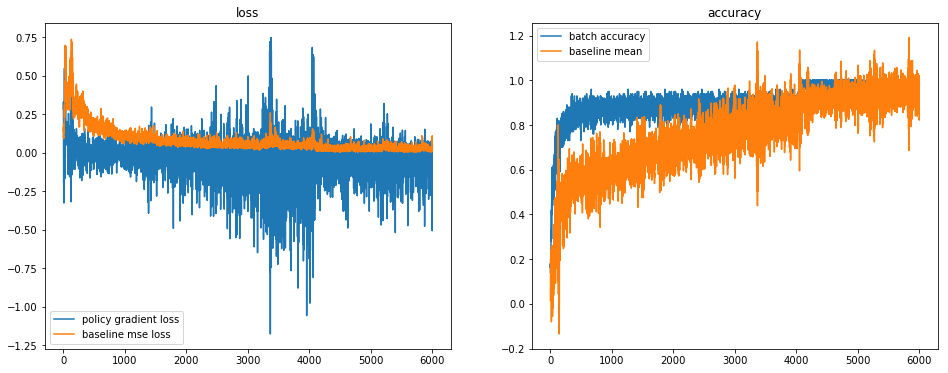

In [9]:
npstats = np.array(stats)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
#plt.plot(npstats[:, 0])
plt.plot(npstats[:, 1])
plt.plot(npstats[:, 2])
#plt.legend(['total loss', 'policy gradient loss', 'baseline mse loss'])
plt.legend(['policy gradient loss', 'baseline mse loss'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(npstats[:, 3])
plt.plot(npstats[:, 4])
plt.legend(['batch accuracy', 'baseline mean'])
#plt.legend(['batch accuracy'])
plt.title('accuracy')

In [10]:
a = np.zeros((x_test.shape[0], 1))
y_pred, baselines = model.predict([x_test, a])
y_pred = np.argmax(y_pred, axis=1)
print(np.mean(y_pred == y_test))

0.9836
